# Using ZEMAX and PyZDDE with IPython notebook

**Summary:**

Here we demonstrate how to use Zemax with PyZDDE and the IPython notebook. We also demonstrate how to create two parallel DDE links to two instances of Zemax.



Using the [IPython notebook](http://ipython.org/notebook.html) with ZEMAX is attractive for the following reasons:

*  The notebook provides an interactive, computational environment similar to Mathematica's CDF where one can combine text, figures, computation, etc. within a single document. Personally, it really helps me to tinker and explore various stages of designs and optical simulations. I use the notebook extensively during the initial phases of a project.
*  It can provide a way for quick documentation of a lens design process as one progress through the design, including embedding intermittent figures, prescription files, thought process, etc.
*  It can also be used in an educational setting, such as to create and distribute lectures, notes, etc.

Before using the notebook for communicating with ZEMAX, ensure that ZEMAX is running. Once verified, a pyzdde object can be created and initialized as shown below.  

In [1]:
import os
import pyzdde.zdde as pyz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
l1 = pyz.createLink() # create a DDE link object for communication

Load an existing lens design file

In [3]:
zfile = os.path.join(l1.zGetPath()[1], 'Sequential', 'Objectives', 'Cooke 40 degree field.zmx')

In [4]:
l1.zLoadFile(zfile)

0

The following figure is the 2-D Layout plot of the lens.

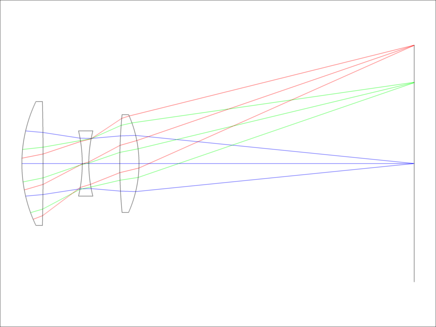

In [5]:
l1.ipzCaptureWindow('Lay')

and here is the ray-fan analysis plot.

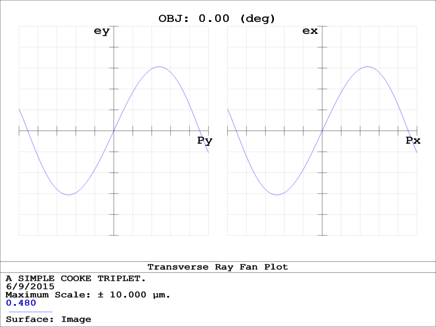

In [6]:
l1.ipzCaptureWindow('Ray', gamma=0.4)

Note that there are few other options for retrieving and plotting analysis plots from Zemax. They are discussed in a separate notebook. However, here is one worth quickly mentioning. You can ask `ipzCaptureWindow()` to just return the image pixel array instead of directly plotting. Then you can use matplotlib (or any other plotting libraries) to plotting. Here is an example:

In [7]:
lay_arr = l1.ipzCaptureWindow('Lay', percent=15, gamma=0.08, retArr=True)

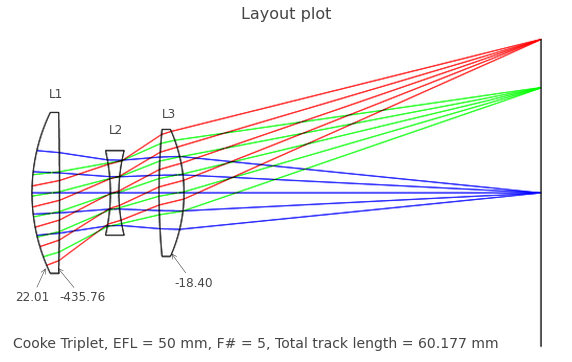

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pyz.imshow(lay_arr, cropBorderPixels=(5, 5, 1, 90), fig=fig, faxes=ax)
ax.set_title('Layout plot', fontsize=16)
# Annotate Lens numbers
ax.text(41, 70, "L1", fontsize=12)
ax.text(98, 105, "L2", fontsize=12)
ax.text(149, 89, "L3", fontsize=12) 
# Annotate the lens with radius of curvature information
col = (0.08,0.08,0.08)
s1_r = 1.0/l1.zGetSurfaceData(1,2)
ax.annotate("{:0.2f}".format(s1_r), (37, 232), (8, 265), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
s2_r = 1.0/l1.zGetSurfaceData(2,2)
ax.annotate("{:0.2f}".format(s2_r), (47, 232), (50, 265), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
s6_r = 1.0/l1.zGetSurfaceData(6,2)
ax.annotate("{:0.2f}".format(s6_r), (156, 218), (160, 251), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
ax.text(5, 310, "Cooke Triplet, EFL = {} mm, F# = {}, Total track length = {} mm"
        .format(50, 5, 60.177), fontsize=14) 
plt.show()

Now, a second `pyzdde` object is created to communicate with a second ZEMAX server. Note that the first object is still present.

In [9]:
l2 = pyz.createLink() # create a second DDE communication link object

Set up lens surfaces in the second ZEMAX DDE server. Towards the end, `zPushLens()` is called so that the LDE is updated with the just-made lens.

In [10]:
from __future__ import division  # this is required for floating point division

# Erase all lens data in the LDE (good practice)
l2.zNewLens()

# Wavelength data
wavelengths = (0.48613270, 0.58756180, 0.65627250) #mm
weights = (1.0, 1.0, 1.0)

l2.zSetWaveTuple((wavelengths, weights))
l2.zSetPrimaryWave(2) # Set 0.58756180 as primary

# System aperture data, and global reference surface.
aType, stopSurf, appValue = 0, 1, 100 # EPD,STO is 1st sur, value = 100

l2.zSetSystemAper(aType, stopSurf, appValue)

# General data (we need set whatever is really required ... the following
# is just shown as an example)
unitCode, rayAimingType, globalRefSurf = 0, 0, 1  # mm, off,ref=1st surf
useEnvData, temp, pressure = 0, 20, 1             # off, 20C, 1ATM

setSystemArg = (unitCode, stopSurf, rayAimingType,
                useEnvData, temp, pressure, globalRefSurf)
l2.zSetSystem(*setSystemArg)

# Setup Field data
l2.zSetField(0, 0, 3, 1)                       # number of fields = 3 
l2.zSetField(1, 0, 0)                          # 1st field, on-axis x, on-axis y, weight = 1 (default)
l2.zSetField(3, 0, 10, 1.0, 0.0, 0.0, 0.0)     # 2nd field
l2.zSetField(2,0,5,2.0,0.5,0.5,0.5,0.5, 0.5)   # 3rd field

#Setup the system, wavelength, (but not the field points)
l2.zInsertSurface(2)
l2.zInsertSurface(3)

#Set surface data, note that by default, all surfaces are Standard type
# OBJ: Surface 0
l2.zSetSurfaceData(0,3,500.00)   #OBJ thickness = 0.5 m or 500 mm
#STO: Surface 1
l2.zSetSurfaceData(1,2,0)        #STO Radius = Infinity
l2.zSetSurfaceData(1,3,20.00)    #STO Thickness = 20 mm
l2.zSetSurfaceData(1,5,50.00)    #STO Semi-diameter = 50 mm
#Surface 2
l2.zSetSurfaceData(2,2,1/150)    #Surf2 Radius = 150 mm
l2.zSetSurfaceData(2,3,100.0)    #Surf2 Thickness = 100 mm
l2.zSetSurfaceData(2,4,'BK7')    #Surf2 Glass, type = BK7
l2.zSetSurfaceData(2,5,65.00)    #Surf2 Semi-diameter = 65.00 mm
#Surface 3
l2.zSetSurfaceData(3,2,-1/600)   #Surf3 Radius = -600 mm
l2.zSetSurfaceData(3,3,300.00)   #Surf3 Thickness = 184 mm
l2.zSetSurfaceData(3,5,65.00)    #Surf3 Semi-diameter = 65.00 mm

# Perform Quick Focus
l2.zQuickFocus(3,1)

# push lens
l2.zPushLens(update=1)

0

Layout plot of the second lens

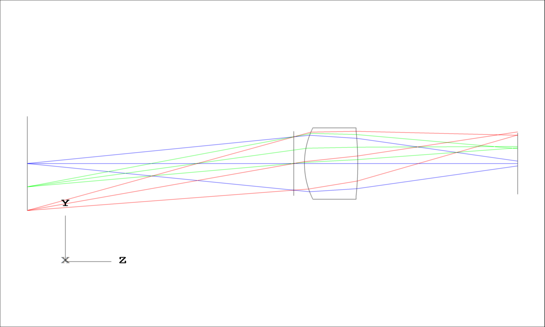

In [11]:
l2.ipzCaptureWindow('L3d')

Spot diagram of the second lens

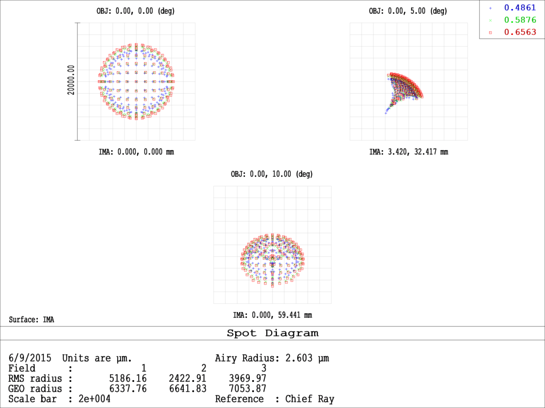

In [18]:
l2.ipzCaptureWindow('Spt', percent=15, gamma=0.55)

Just to demonstrate that the first lens (in the first ZEMAX server) is still available, the Layout plot is rendered again.

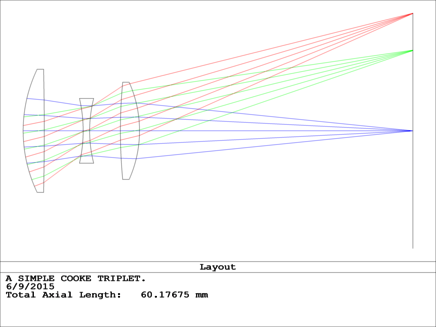

In [15]:
l1.ipzCaptureWindow('Lay')

Spot diagram of the first lens

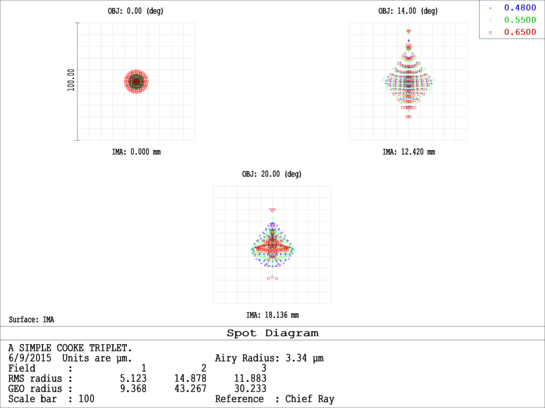

In [17]:
l1.ipzCaptureWindow('Spt', percent=15, gamma=0.55)

MTF plot of the first lens

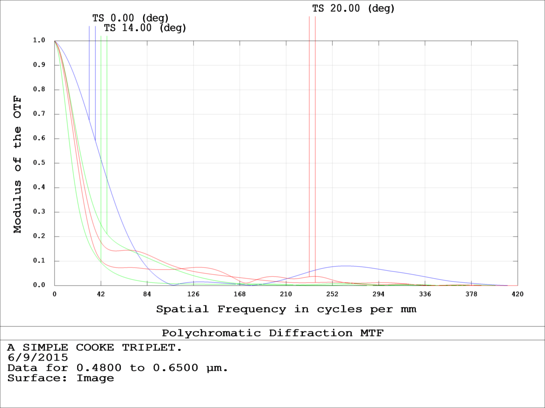

In [19]:
l1.ipzCaptureWindow('Mtf', percent=15, gamma=0.5)

Lastly, here is an example of how execute a ZPL macro using the PyZDDE. 

Since ZEMAX can execute ZPL macros present in a set folder (generally the default macro folder in the data folder), the appropriate macro folder path needs to be set if it is not the default macro folder path.

In [20]:
l1.zSetMacroPath(r"C:\PROGRAMSANDEXPERIMENTS\ZEMAX\Macros")

0

The following command executes the ZPL macro 'GLOBAL' provided by ZEMAX. The macro computes the global vertex coordinates or orientations surface by surface by surface, and outputs a text window within the ZEMAX environment. Maximize (if required) the ZEMAX application window to see the output after executing the following command.

In [21]:
l1.zExecuteZPLMacro('GLO')

0

Close the DDE links

In [22]:
pyz.closeLink()